In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

In [20]:
df = pd.read_csv("merged_songs.csv") 
df.head()

,artist,song,duration_ms,explicit,year,popularity,danceability,energy,key,loudness,...,instrumentalness,liveness,valence,tempo,genre,date,rank,last-week,peak-rank,weeks-on-board
0,Britney Spears,Oops!...I Did It Again,3.52,False,2000,77,0.751,0.834,1,-5.444,...,0.000018,0.355,0.894,95.053,pop,2000-09-02,96,90.0,9,20
1,Britney Spears,Oops!...I Did It Again,3.52,False,2000,77,0.751,0.834,1,-5.444,...,0.000018,0.355,0.894,95.053,pop,2000-08-26,90,85.0,9,19
2,Britney Spears,Oops!...I Did It Again,3.52,False,2000,77,0.751,0.834,1,-5.444,...,0.000018,0.355,0.894,95.053,pop,2000-08-19,85,77.0,9,18
3,Britney Spears,Oops!...I Did It Again,3.52,False,2000,77,0.751,0.834,1,-5.444,...,0.000018,0.355,0.894,95.053,pop,2000-08-12,77,49.0,9,17
4,Britney Spears,Oops!...I Did It Again,3.52,False,2000,77,0.751,0.834,1,-5.444,...,0.000018,0.355,0.894,95.053,pop,2000-08-05,49,35.0,9,16


In [27]:
# Keep only numerical columns
df = df.dropna()
numerical_data = df.select_dtypes(include=[np.number])

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numerical_data)
scaled_data

array([[-0.47265192, -1.55465395,  0.67529643, ...,  2.50371491,
        -0.45937427,  0.29458391],
       [-0.47265192, -1.55465395,  0.67529643, ...,  2.29432195,
        -0.45937427,  0.20559065],
       [-0.47265192, -1.55465395,  0.67529643, ...,  1.95929322,
        -0.45937427,  0.11659739],
       ...,
       [-0.35759337,  1.73957826,  1.06612188, ..., -0.888451  ,
        -0.69370248, -1.12930829],
       [-0.35759337,  1.73957826,  1.06612188, ..., -1.09784396,
        -0.69370248, -1.21830156],
       [-0.35759337,  1.73957826,  1.06612188, ..., -0.97220819,
        -0.69370248, -1.30729482]])

In [28]:
# Perform PCA
pca = PCA()
pca_data = pca.fit_transform(scaled_data)
explained_variance = pca.explained_variance_ratio_

In [29]:
cumulative_variance = np.cumsum(explained_variance)
intrinsic_dim = np.argmax(cumulative_variance >= 0.90) + 1  # 90% variance explained

In [30]:
# Perform K-Means clustering for k=1 to 10
mse_scores = []
k_values = range(1, 11)
cluster_assignments = {}

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(pca_data[:, :intrinsic_dim])
    mse_scores.append(kmeans.inertia_)
    cluster_assignments[k] = kmeans.labels_

# Find elbow point for K-Means
k_elbow = np.argmin(np.diff(mse_scores, 2)) + 2

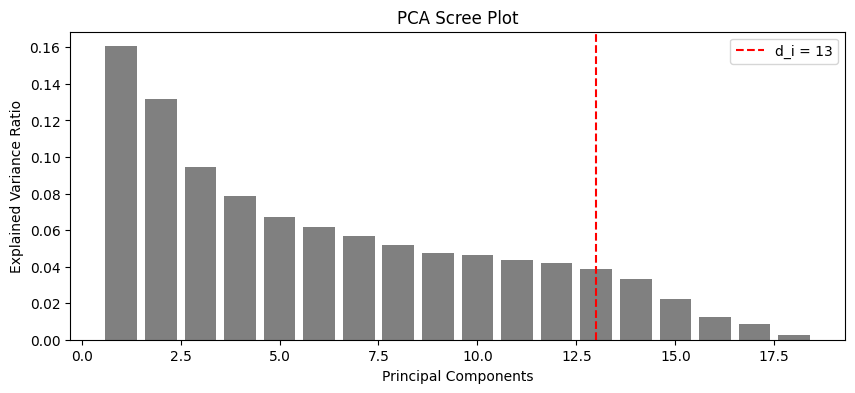

In [31]:
# Plot Scree Plot (PCA Eigenvalues)
plt.figure(figsize=(10, 4))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, color="gray")
plt.axvline(intrinsic_dim, color='red', linestyle='dashed', label=f"d_i = {intrinsic_dim}")
plt.xlabel("Principal Components")
plt.ylabel("Explained Variance Ratio")
plt.title("PCA Scree Plot")
plt.legend()
plt.show()

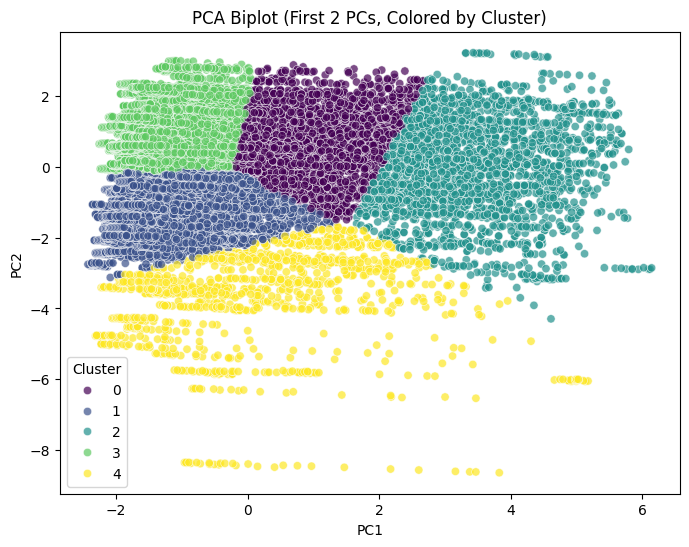

In [33]:
plt.figure(figsize=(8, 6))
kmeans_best = KMeans(n_clusters=k_elbow, random_state=42, n_init=10)
labels = kmeans_best.fit_predict(pca_data[:, :2])
sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=labels, palette='viridis', alpha=0.7)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA Biplot (First 2 PCs, Colored by Cluster)")
plt.legend(title="Cluster")
plt.show()

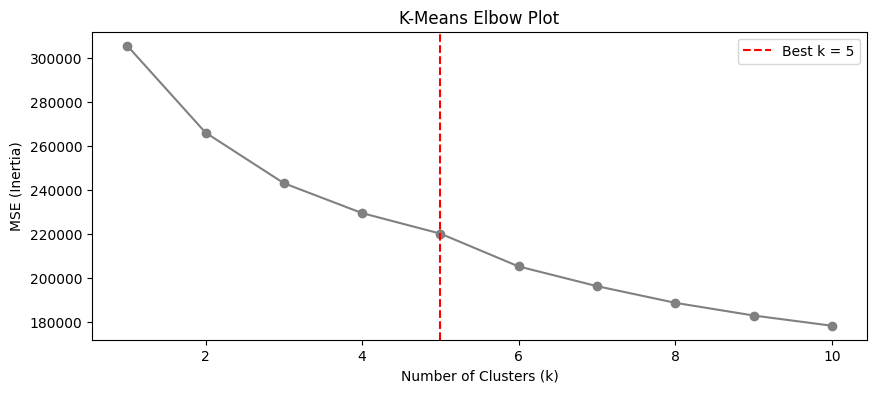

In [32]:
plt.figure(figsize=(10, 4))
plt.plot(k_values, mse_scores, marker='o', linestyle='-', color='gray')
plt.axvline(k_elbow, color='red', linestyle='dashed', label=f"Best k = {k_elbow}")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("MSE (Inertia)")
plt.title("K-Means Elbow Plot")
plt.legend()
plt.show()

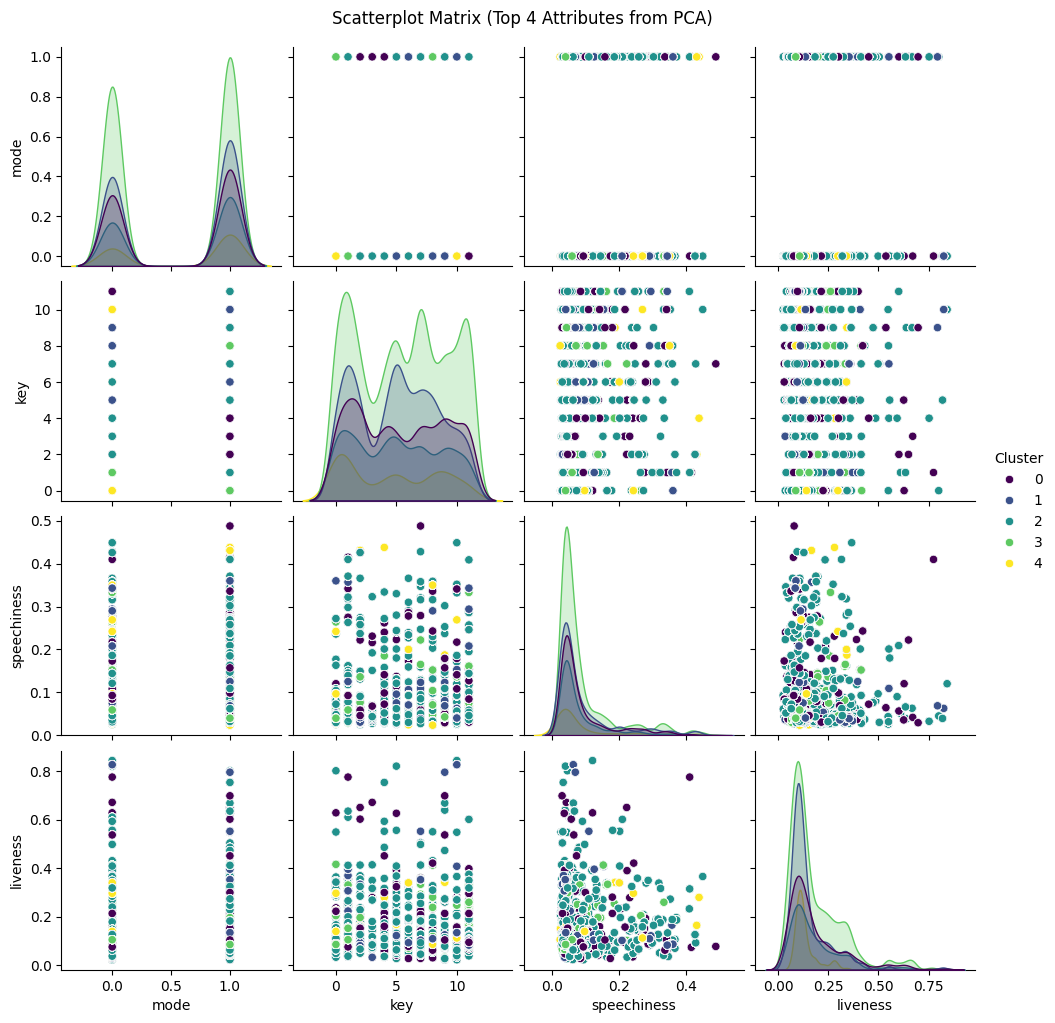

In [35]:
# Select Top 4 Attributes based on PCA Loadings
top4_attributes = np.argsort(np.sum(np.abs(pca.components_[:intrinsic_dim]) ** 2, axis=0))[-4:]
top4_features = numerical_data.columns[top4_attributes]

# Plot Scatterplot Matrix
sns.pairplot(df[top4_features].assign(Cluster=labels), hue="Cluster", palette='viridis')
plt.suptitle("Scatterplot Matrix (Top 4 Attributes from PCA)", y=1.02)
plt.show()